In [40]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import copy
import matplotlib.pyplot as plt
import torch
from PIL import Image
from PIL import Image, ImageDraw
from torch.utils.data import Dataset
import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
 #  for filename in filenames:
  #     print(os.path.join(dirname, filename))

# TensorFlow version and GPU availability
print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))


TensorFlow version: 2.18.0
GPU Available: []


In [41]:
os.listdir('/kaggle/input/histopathologic-cancer-detection/')


['sample_submission.csv', 'train_labels.csv', 'test', 'train']

In [42]:
#total samples 

print('Train Images = ',len(os.listdir('../input/histopathologic-cancer-detection/train')))
print('Test Images = ',len(os.listdir('../input/histopathologic-cancer-detection/test')))


Train Images =  220025
Test Images =  57458


In [43]:
train = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')
print('Shape of DataFrame',train.shape)
train.head()

Shape of DataFrame (220025, 2)


id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0

In [44]:
imgpath ="/kaggle/input/histopathologic-cancer-detection/train/" # training data is stored in this folder
malignant = train.loc[train['label']==1]['id'].values    # get the ids of malignant cases
normal = train.loc[train['label']==0]['id'].values       # get the ids of the normal cases


In [45]:
def plot_fig(ids,title,nrows=5,ncols=15):

    fig,ax = plt.subplots(nrows,ncols,figsize=(18,6))
    plt.subplots_adjust(wspace=0, hspace=0) 
    for i,j in enumerate(ids[:nrows*ncols]):
        fname = os.path.join(imgpath ,j +'.tif')
        img = Image.open(fname)
        idcol = ImageDraw.Draw(img)
        idcol.rectangle(((0,0),(95,95)),outline='white')
        plt.subplot(nrows, ncols, i+1) 
        plt.imshow(np.array(img))
        plt.axis('off')

    plt.suptitle(title, y=0.94)

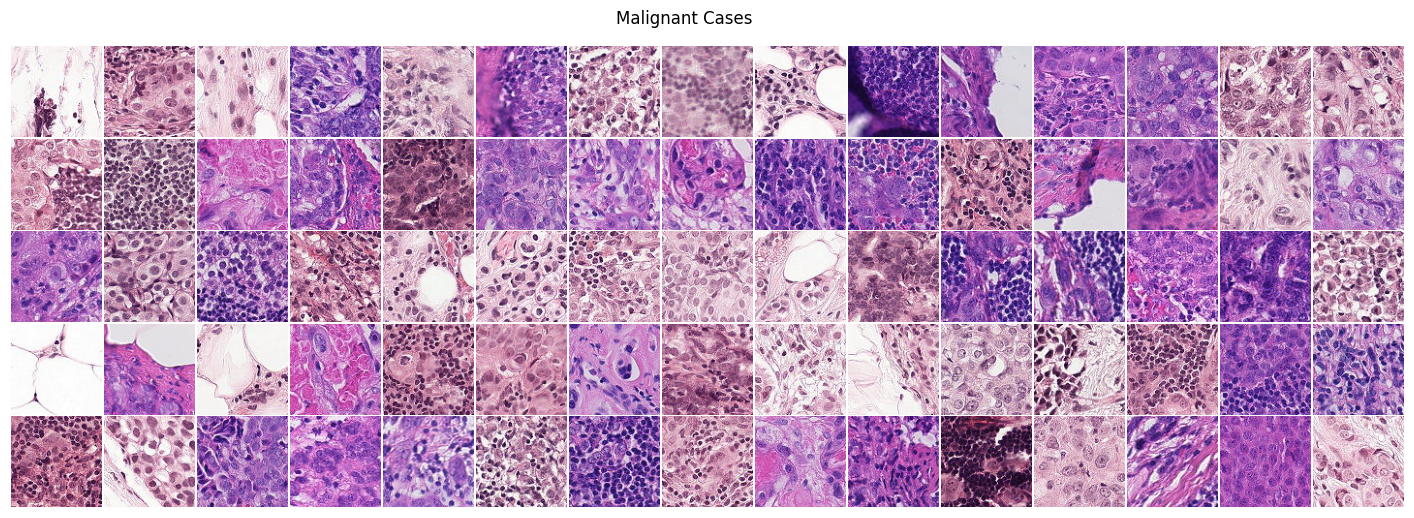

In [46]:
plot_fig(malignant,'Malignant Cases')

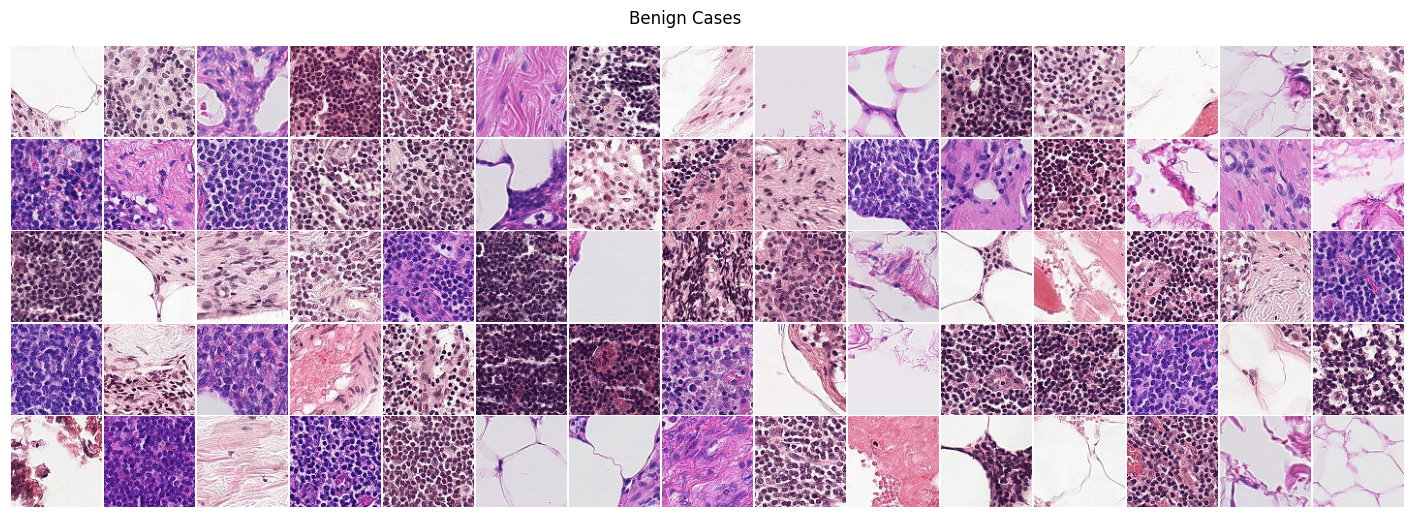

In [47]:
plot_fig(normal,'Benign Cases')

In [48]:
# Load MNIST dataset manually
with np.load('/kaggle/input/mnist-data/mnist.npz') as data:
    X_train, y_train = data['x_train'], data['y_train']
    X_test, y_test = data['x_test'], data['y_test']

# Normalize pixel values to range [0, 1]
X_train, X_test = X_train / 255.0, X_test / 255.0

# Reshape data to add a channel dimension (for CNN input)
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)


# Print shape information
print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

Training data shape: (60000, 28, 28, 1)
Test data shape: (10000, 28, 28, 1)


In [49]:

# Build the CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Regularization to prevent overfitting
    layers.Dense(10, activation='softmax')  # Output layer for classification
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [50]:
# Data augmentation for training data
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)
datagen.fit(X_train.reshape(-1,28,28,1))

In [51]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [52]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), callbacks=[callback])

Epoch 1/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - accuracy: 0.8705 - loss: 0.4218 - val_accuracy: 0.9856 - val_loss: 0.0462
Epoch 2/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.9756 - loss: 0.0837 - val_accuracy: 0.9882 - val_loss: 0.0342
Epoch 3/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.9824 - loss: 0.0605 - val_accuracy: 0.9887 - val_loss: 0.0329
Epoch 4/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.9848 - loss: 0.0518 - val_accuracy: 0.9898 - val_loss: 0.0300
Epoch 5/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.9875 - loss: 0.0404 - val_accuracy: 0.9922 - val_loss: 0.0247
Epoch 6/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.9903 - loss: 0.0318 - val_accuracy: 0.9923 - val_loss: 0.0241
Epoch 7/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.9915 - loss: 0.0292 - val_accuracy: 0.9913 - val_loss: 0.0273
Epoch 8/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.9921 -

In [ ]:
history = model.fit(X_train.reshape(-1, 28, 28, 1), y_train, epochs=30, validation_data=(X_test.reshape(-1, 28, 28, 1), y_test))

Epoch 1/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.9899 - loss: 0.0319 - val_accuracy: 0.9918 - val_loss: 0.0265
Epoch 2/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.9917 - loss: 0.0251 - val_accuracy: 0.9933 - val_loss: 0.0228
Epoch 3/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.9926 - loss: 0.0240 - val_accuracy: 0.9929 - val_loss: 0.0226
Epoch 4/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.9943 - loss: 0.0184 - val_accuracy: 0.9904 - val_loss: 0.0375
Epoch 5/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.9941 - loss: 0.0181 - val_accuracy: 0.9925 - val_loss: 0.0282
Epoch 6/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.9945 - loss: 0.0165 - val_accuracy: 0.9943 - val_loss: 0.0210
Epoch 7/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.9962 - loss: 0.0113 - val_accuracy: 0.9935 - val_loss: 0.0209
Epoch 8/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.9955 -

In [ ]:
#Evaluate on test data
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"\nTest accuracy: {test_acc:.4f}")


In [ ]:
# Generate predictions for the test set
predictions = model.predict(X_test)

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Compare predictions with true labels
print("Predictions:", predicted_labels[:10])  # View first 10 predictions
print("True Labels:", y_test[:10])            # View first 10 true labels

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()